In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import datetime
import math
import random
import numpy as np
import pandas as pd
import re

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/ig/ecom/Ecommerce.csv',  encoding="iso8859-1")


In [ ]:
df0 = df_raw.copy()

In [ ]:
df0.rename(columns={"InvoiceNo":"invoice_num", 
                   "StockCode":"stock_code", 
                  "Description":"description", 
                  "Quantity":"quantity", 
                  "InvoiceDate":"invoice_date", 
                  "UnitPrice":"unit_price", 
                  "CustomerID":"customer_id", 
                  "Country":"country"}, inplace=True)

In [ ]:
df0.drop(df0.columns[df0.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [ ]:
df1=df0.dropna()

In [ ]:
df1.head()

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [ ]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')



In [ ]:
# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

change the invoice number

In [ ]:
df1.loc[df1['invoice_num'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2017-12-07,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,17315,United Kingdom


In [ ]:
df_aux2 = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

In [ ]:
print('Unique stock codes with letters: {}'.format(df_aux2['stock_code'].unique()))
print('Percentage of unique stock codes with letters: {}'.format(df_aux2['stock_code'].shape[0] / df1.shape[0]))

Unique stock codes with letters: ['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK']
Percentage of unique stock codes with letters: 0.004360554434418392


In [ ]:

df2 = df1.copy()


In [ ]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

In [ ]:
# categorical attributes
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

In [ ]:
# description
df2 = df2.drop(columns='description', axis=1)

In [ ]:
# map
df2 = df2[~df2['stock_code'].isin(['European Community',  'Unspecified'])]

In [ ]:
# bad customer ( devolution and small basket)
df2 = df2[~df2['customer_id'].isin([16446])]

In [ ]:
# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

In [ ]:
df3 = df2.copy()

In [ ]:
df_ref = df3.drop(['invoice_num', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [ ]:
# gross revenue - Quantity x price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']
                                

In [ ]:
# monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

In [ ]:
# days from last purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [ ]:
# frecuency
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_num']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_num': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
dtype: int64

In [ ]:
# total number of products
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
dtype: int64

In [ ]:
# number of products types
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )

In [ ]:
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
dtype: int64

In [ ]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )

In [ ]:
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
qtde_invoices    27
qtde_items       27
qtde_products    27
avg_ticket       27
dtype: int64

In [ ]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date


In [ ]:
df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )


In [ ]:
df_aux.head()

,customer_id,invoice_date,next_customer_id,previous_date,avg_recency_days
61619,12346,2017-01-16,NaN,NaT,NaN
14938,12347,2016-12-05,12346.0,2017-01-16,NaN
72246,12347,2017-01-24,12347.0,2016-12-05,50.0
148285,12347,2017-04-05,12347.0,2017-01-24,71.0
220572,12347,2017-06-07,12347.0,2017-04-05,63.0


In [ ]:
df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()


In [ ]:
# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

In [ ]:
# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1387
dtype: int64

In [ ]:
# purchase frequency
df_aux = ( df2_purchases[['customer_id', 'invoice_num', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_num', 'count' ) ) ).reset_index()

In [ ]:
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

In [ ]:
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )


In [ ]:
df_ref.isna().sum()


customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1387
frequency             27
dtype: int64

In [ ]:
# number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

In [ ]:
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

In [ ]:
# basket size, being Invoice No = purchase, Stock Code = Product, and Quantity = Item
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_num', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_num', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

In [ ]:
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

In [ ]:
# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qtde_invoices         27
qtde_items            27
qtde_products         27
avg_ticket            27
avg_recency_days    1387
frequency             27
qtde_returns           0
avg_basket_size       27
dtype: int64

In [ ]:
# unique basket size
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_num', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_num', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

In [ ]:
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

In [ ]:
# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
qtde_invoices               27
qtde_items                  27
qtde_products               27
avg_ticket                  27
avg_recency_days          1387
frequency                   27
qtde_returns                 0
avg_basket_size             27
avg_unique_basket_size      27
dtype: int64

In [ ]:
 df4 = df_ref.dropna()

In [ ]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [ ]:
df42 = df4.drop('customer_id', axis=1)
sns.pairplot(df42)

Lets do some feature selection

gross_revenue - Amount contributed by customers

recency_days- Recency days as described earlier defines purchase cycle period

qtde_invoices -  It counts the total frequency of purchase

qtde_items-   Count of total items

qtde_products- Count of difrrent Products

qtde_returns-  Count of no of returns made

In [ ]:
cols_selected = ['gross_revenue', 'recency_days', 'qtde_invoices',
                 'qtde_items', 'qtde_products', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [ ]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


In [ ]:

from sklearn import preprocessing as pp

In [ ]:
# preprocessing
mm = pp.MinMaxScaler()

In [ ]:
df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['qtde_invoices'] = mm.fit_transform(df43[['qtde_invoices']])
df43['qtde_items'] = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mm.fit_transform(df43[['qtde_products']])
# df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
# df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
# df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mm.fit_transform(df43[['qtde_returns']])
# df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
# df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

In [ ]:
X = df43.copy()

In [ ]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,qtde_returns
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.004438
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.003883
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.005547
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000000
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.002441


***PCA  Principal Component Analysis***

What is PCA?


Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.
Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.
  So to sum up, the idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.

In [ ]:
#pca package drom sklearn
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)


It will break all the features in two features

In [ ]:
pca.fit(X)


PCA(n_components=2)

Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. Here we have reduced our variables to two principal componets where we would prokect our data points

In [ ]:
x_pca = pca.transform(X)


Now we can transform this data to its first 2 principal components.



In [ ]:
x_pca.shape


(2972, 2)

Hurray! We can see that our features have been reduced to two features

In [ ]:
X.shape

In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

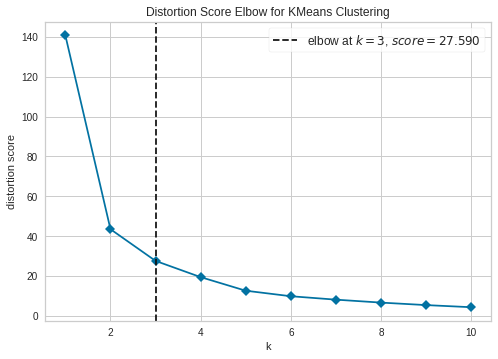

In [ ]:

# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,11), timings= False)
visualizer.fit(x_pca)        # Fit data to visualizer
visualizer.show()    

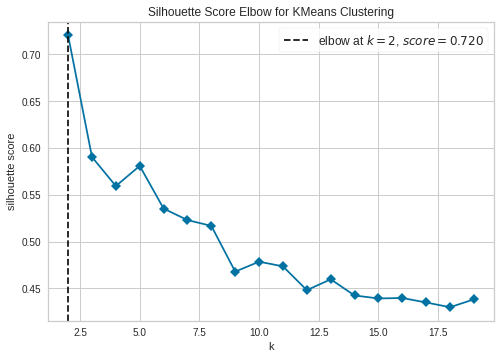

In [ ]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= False)
visualizer.fit(x_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
km = KMeans(n_clusters=3)
y_pre 
X['clusters']= y_predicted
X

,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,qtde_returns,clusters
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.004438,1
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.003883,0
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.005547,0
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000000,2
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.002441,1
...,...,...,...,...,...,...,...
4294,0.001673,0.029491,0.000000,0.001936,0.003700,0.003772,0
4309,0.002508,0.018767,0.009756,0.002576,0.001786,0.005547,0
4313,0.003891,0.002681,0.009756,0.003719,0.055378,0.000000,0
4318,0.001059,0.021448,0.014634,0.001326,0.015184,0.000000,0


In [ ]:
new2_df=df4.copy()

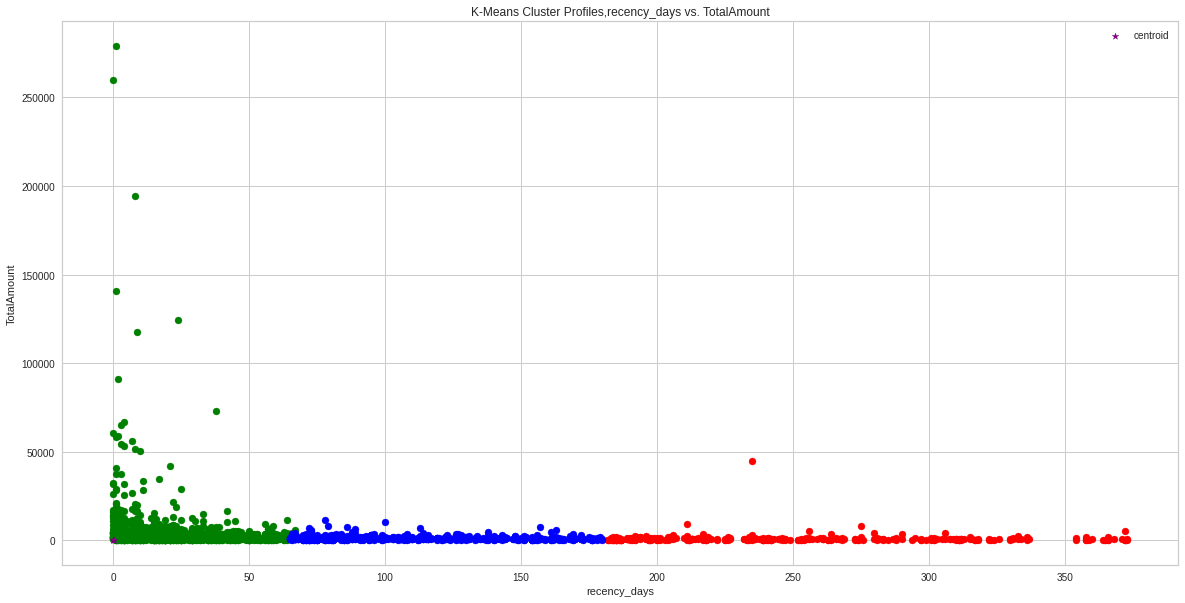

In [ ]:
# Visualize the clusters with original data
new2_df['clusters']= y_predicted
df1 = new2_df[new2_df.clusters==0]
df2 = new2_df[new2_df.clusters==1]
df3 = new2_df[new2_df.clusters==2]
plt.figure(figsize=(20,10))
plt.scatter(df1.recency_days,df1['gross_revenue'],color='green')
plt.scatter(df2.recency_days,df2['gross_revenue'],color='red')
plt.scatter(df3.recency_days,df3['gross_revenue'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.legend()
plt.xlabel('recency_days')
plt.ylabel('TotalAmount')
plt.title('K-Means Cluster Profiles,recency_days vs. TotalAmount')
plt.show()

**CONCLUSION**


The K-Means model segments the data into distinct clusters based on customer's Recency(Last_transaction) and Monetary(TotalAmount).

* Cluster 0 consists of customers with the last_transaction between 0 and 70 days, and total amount spent between 0 to $3000

* Cluster 1 consist of customers with the last_transaction between 70 and 180 days, and total amount spent between 0 and $1500

* Cluster 2 consits of custoemrs with the last_transaction between 170 and 370 days, and total amount spent between $1200 and $1500

**WE CAN SEE THAT  RESULTS  OBTAINED FROM PCA ARE NOT THAT MUCH DIFFERENT**